In [3]:
import os
import torch
import datetime
from model import *
from tqdm import tqdm
from PIL import Image
from skimage import io
from scipy.io import loadmat, savemat
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

TODO:

- Data augmentation
- Test out different loss function (can learn from 0-1 output instead of sigmoid?)
- Train different models in encoder-decoder format
- Find a way to calculate the training accuracy?
- Hyperparameter tuning
- Save and load model
- Classify the nucleus based on multiclass?

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


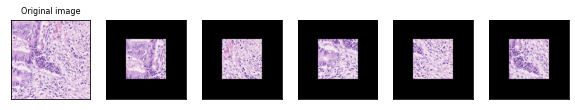

<Figure size 7200x7200 with 0 Axes>

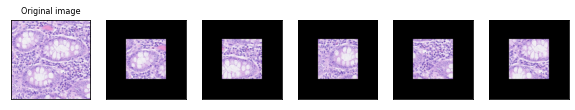

<Figure size 7200x7200 with 0 Axes>

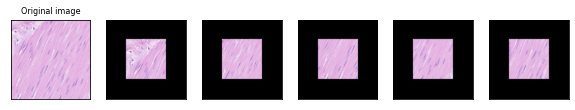

<Figure size 7200x7200 with 0 Axes>

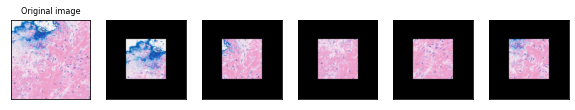

<Figure size 7200x7200 with 0 Axes>

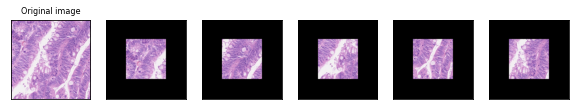

<Figure size 7200x7200 with 0 Axes>

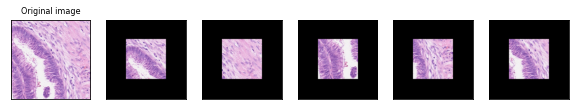

<Figure size 7200x7200 with 0 Axes>

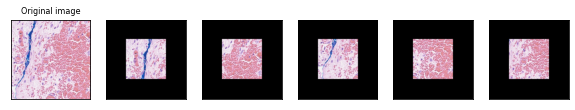

<Figure size 7200x7200 with 0 Axes>

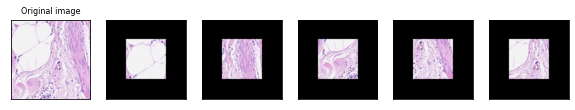

<Figure size 7200x7200 with 0 Axes>

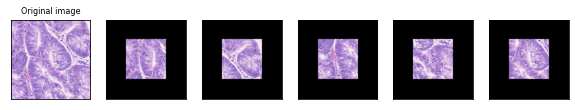

<Figure size 7200x7200 with 0 Axes>

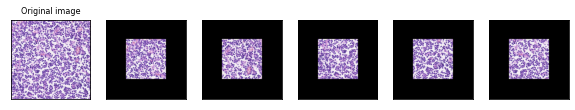

<Figure size 7200x7200 with 0 Axes>

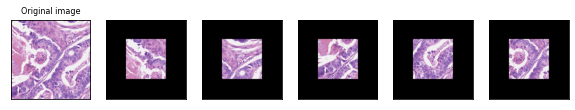

<Figure size 7200x7200 with 0 Axes>

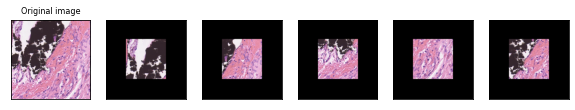

<Figure size 7200x7200 with 0 Axes>

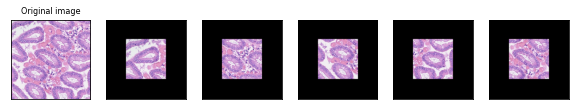

<Figure size 7200x7200 with 0 Axes>

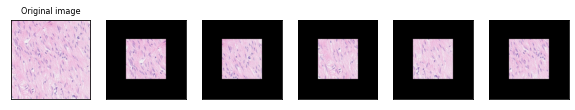

<Figure size 7200x7200 with 0 Axes>

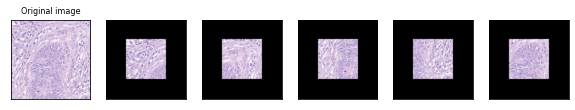

<Figure size 7200x7200 with 0 Axes>

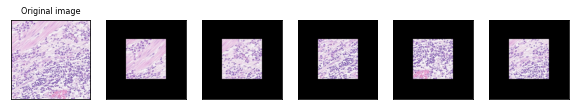

<Figure size 7200x7200 with 0 Axes>

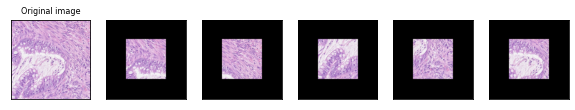

<Figure size 7200x7200 with 0 Axes>

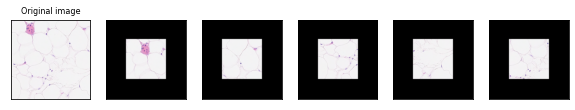

<Figure size 7200x7200 with 0 Axes>

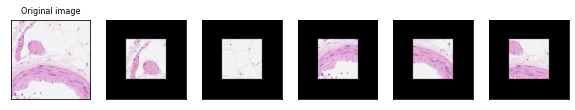

<Figure size 7200x7200 with 0 Axes>

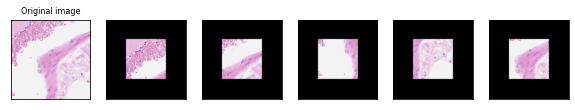

<Figure size 7200x7200 with 0 Axes>

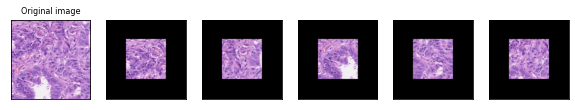

<Figure size 7200x7200 with 0 Axes>

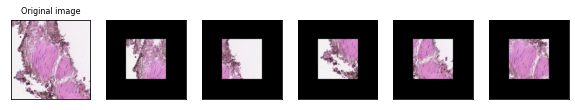

<Figure size 7200x7200 with 0 Axes>

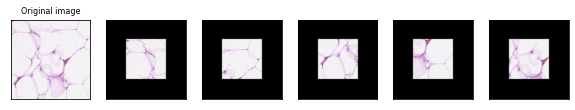

<Figure size 7200x7200 with 0 Axes>

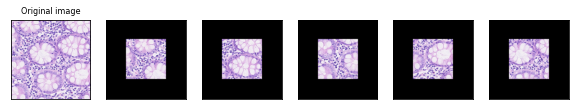

<Figure size 7200x7200 with 0 Axes>

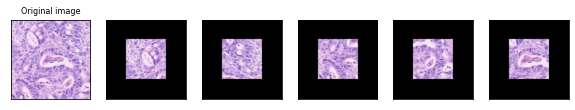

<Figure size 7200x7200 with 0 Axes>

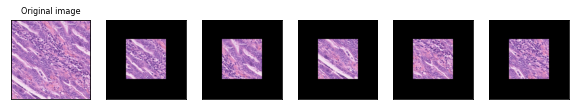

<Figure size 7200x7200 with 0 Axes>

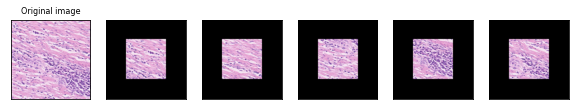

<Figure size 7200x7200 with 0 Axes>

In [73]:
%pylab inline
import torchvision.transforms as T
from torch.nn import ConstantPad2d
import numpy as np

def plot(imgs, orig_img, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False, figsize=(10, 10))
    fig = plt.figure(figsize=(100, 100))
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()
    
def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 10)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value

def five_crop():
    root_dir = "./Train"
    fileNames = [i[:-4] for i in sorted(os.listdir(root_dir+"/Labels/"))]
    img_path = "./cropped_train/Images/"
    label_path = "./cropped_train/Labels/"
    for idx in range(len(fileNames)):
        size = 500
        img_name = os.path.join(root_dir,"Images", fileNames[idx])+".png"
        mask_name = os.path.join(root_dir,"Labels", fileNames[idx])+".mat"
        dictmat = loadmat(mask_name)
        orig_img = Image.open(img_name)
        (top_left, top_right, bottom_left, bottom_right, center) = T.FiveCrop(size=(size, size))(orig_img)
        cropped = [top_left, top_right, bottom_left, bottom_right, center]
        
        orig_img.save(img_path + fileNames[idx] + "_original.png")
        savemat(label_path + fileNames[idx] + "_original.mat", {"inst_map": dictmat["inst_map"]})    
        for img_idx in range(len(cropped)):
            name = ""
            labels = {}
            if img_idx == 0:
                name = "top_left"
                labels["inst_map"] = dictmat["inst_map"][0:size, 0:size]
            elif img_idx == 1:
                name = "top_right"
                labels["inst_map"] = dictmat["inst_map"][0:size, 1000-size:1000]
            elif img_idx == 2:
                name = "bottom_left"
                labels["inst_map"] = dictmat["inst_map"][1000-size:1000, 0:size]
            elif img_idx == 3:
                name = "bottom_right"
                labels["inst_map"] = dictmat["inst_map"][1000-size:1000, 1000-size:1000]
            elif img_idx == 4:
                name = "center"
                mid_height = 1000/2
                mid_weight = 1000/2
                labels["inst_map"] = dictmat["inst_map"][round(mid_height-size/2):round(mid_height+size/2), round(mid_weight-size/2):round(mid_weight+size/2)]
            
            ## pad images and labels
            cropped[img_idx] = T.Pad(padding=250, fill=(0,0,0), padding_mode='constant')(cropped[img_idx])
            labels["inst_map"] = np.pad(labels["inst_map"], 1, pad_with, padder=0)
            ## save 
            cropped[img_idx].save(img_path + fileNames[idx] + "_" +name+".png")            
            savemat(label_path + fileNames[idx] + "_" +name+".mat", labels)           
        plot(cropped, orig_img)
#         if idx == 0:        
#             break
    
five_crop()

In [51]:
before = "./Train/Labels/train_1.mat"
after = "./cropped_train/Labels/train_1_original.mat"

dictmat_before = loadmat(before)
dictmat_after = loadmat(after)
print(dictmat_before["inst_map"] == dictmat_after["inst_map"])

a = np.arange(6)
a = a.reshape((2, 3))
print(a)
pad = np.pad(a, 2, pad_with, padder=100)
print(pad)

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


In [4]:
class CellDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        self.fileNames = [i[:-4] for i in sorted(os.listdir(root_dir+"/Labels/"))]
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.fileNames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,"Images",self.fileNames[idx])+".png"
        image = img = Image.open(img_name).convert('RGB')
        mask_name = os.path.join(self.root_dir,"Labels",self.fileNames[idx])+".mat"
        mask = np.pad((loadmat(mask_name)['inst_map']>=1).astype(int),12)
        if self.transform:
            image = self.transform(image)

        return image, mask

In [5]:
transform = transforms.Compose([
    transforms.Pad(12),
    transforms.ToTensor()    
])

# DataLoader
train_ds = CellDataset(root_dir="./Train", transform = transform)
train_dataloader = DataLoader(train_ds, batch_size=1, shuffle=False)

test_ds = CellDataset(root_dir="./Test", transform = transform)
test_dataloader = DataLoader(test_ds, batch_size=1, shuffle=False)

## Training

In [6]:
def weighted_loss(pred,targ,bce_weight=0.5, smooth=1.):
    
    bce = F.binary_cross_entropy_with_logits(pred.squeeze(dim=1), targ)
    
    pred = torch.sigmoid(pred)
    
    pred = pred.contiguous().squeeze(dim=1)  
    targ = targ.contiguous()  

    intersection = (pred * targ).sum(dim=1).sum(dim=1)
    dice = (1 - ((2. * intersection + smooth) / (pred.sum(dim=1).sum(dim=1) + targ.sum(dim=1).sum(dim=1) + smooth)))
    
    loss = bce * bce_weight + dice.mean() * (1 - bce_weight)
    
    return loss

def train(model, device, train_loader, optimizer, epoch):
    """
    Trains the model on training data
    """
    train_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        model.train()
        data, target = data.to(device), target.to(device).float()

        optimizer.zero_grad()
        output = model(data)
        loss = weighted_loss(output,target,bce_weight=0.3)
        loss.backward()
        optimizer.step()
        
        train_loss+=(loss/len(data)).item()
        # Find accuracy
        
    train_loss /= len(train_loader)

    print('Train Epoch: {} @ {} - Train Loss: {:.4f}'.format(epoch, datetime.datetime.now().time(), train_loss))
    print("Predicted Mask Sigmoid")
    plt.imshow(output.to('cpu').detach().numpy()[0][0],cmap='gray')
    plt.show()
    print("Actual Mask")
    plt.imshow(target.to('cpu').detach()[0],cmap='gray')
    plt.show()

    return train_loss

In [7]:
# Set cpu / gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model and optimizer
model = build_model(device)
model.to(device)

lr = 0.001
optimizer = Adam(model.parameters(), lr=lr)

  0%|          | 0/30 [00:00<?, ?it/s]

Training
Train Epoch: 1 @ 08:21:45.479431 - Train Loss: 0.2317
Predicted Mask Sigmoid


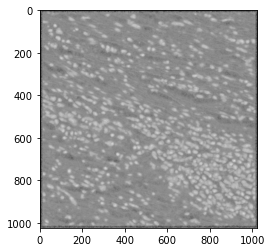

Actual Mask


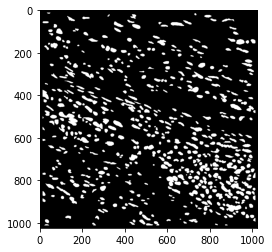

  3%|▎         | 1/30 [00:07<03:38,  7.52s/it]

Train Epoch: 2 @ 08:21:53.123578 - Train Loss: 0.2180
Predicted Mask Sigmoid


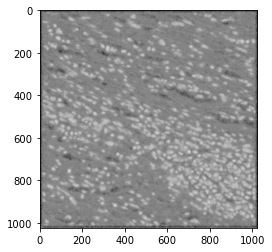

Actual Mask


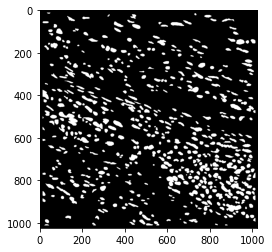

  7%|▋         | 2/30 [00:15<03:31,  7.56s/it]

Train Epoch: 3 @ 08:22:00.850924 - Train Loss: 0.2140
Predicted Mask Sigmoid


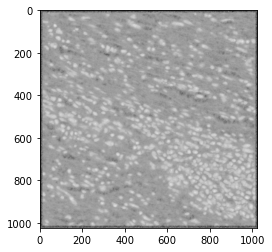

Actual Mask


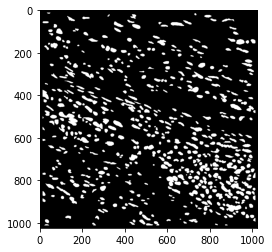

 10%|█         | 3/30 [00:22<03:25,  7.61s/it]

Train Epoch: 4 @ 08:22:08.370275 - Train Loss: 0.2124
Predicted Mask Sigmoid


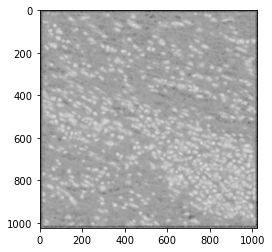

Actual Mask


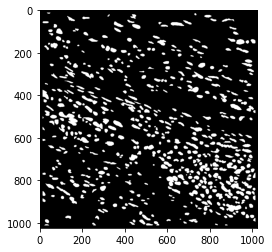

 13%|█▎        | 4/30 [00:30<03:17,  7.58s/it]

Train Epoch: 5 @ 08:22:15.931555 - Train Loss: 0.2126
Predicted Mask Sigmoid


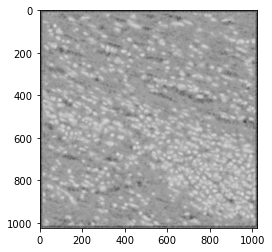

Actual Mask


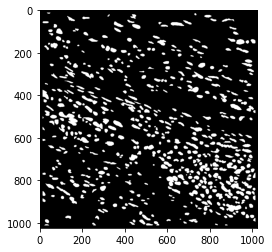

 17%|█▋        | 5/30 [00:37<03:09,  7.58s/it]

Train Epoch: 6 @ 08:22:23.419823 - Train Loss: 0.2138
Predicted Mask Sigmoid


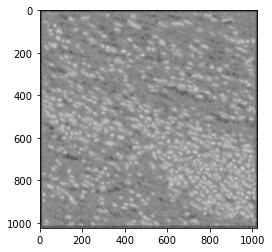

Actual Mask


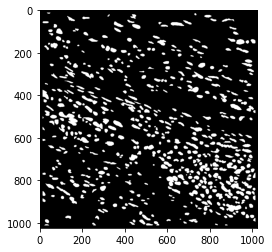

 20%|██        | 6/30 [00:45<03:01,  7.55s/it]

Train Epoch: 7 @ 08:22:31.022254 - Train Loss: 0.2127
Predicted Mask Sigmoid


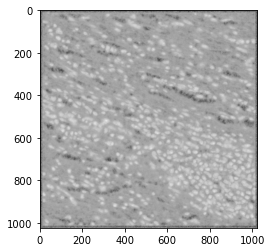

Actual Mask


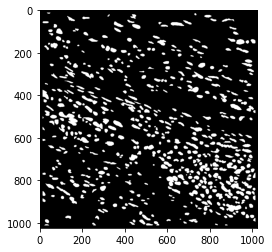

 23%|██▎       | 7/30 [00:53<02:54,  7.59s/it]

Train Epoch: 8 @ 08:22:38.756325 - Train Loss: 0.2099
Predicted Mask Sigmoid


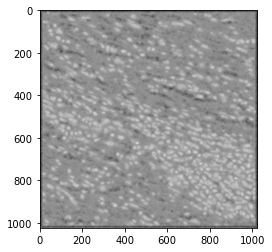

Actual Mask


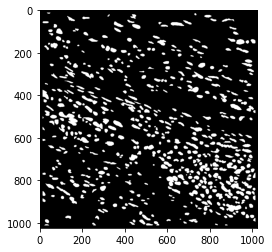

 27%|██▋       | 8/30 [01:00<02:47,  7.61s/it]

Train Epoch: 9 @ 08:22:46.456554 - Train Loss: 0.2054
Predicted Mask Sigmoid


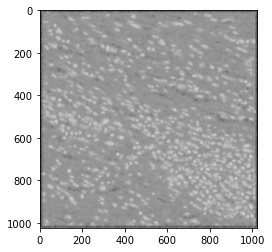

Actual Mask


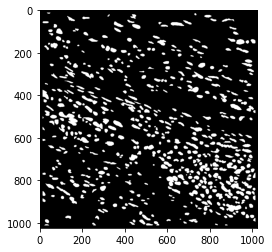

 30%|███       | 9/30 [01:08<02:40,  7.64s/it]

Train Epoch: 10 @ 08:22:54.088132 - Train Loss: 0.2058
Predicted Mask Sigmoid


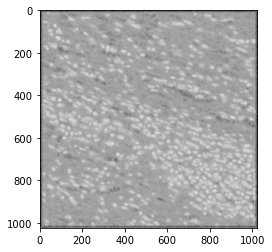

Actual Mask


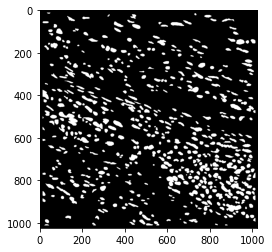

 33%|███▎      | 10/30 [01:16<02:32,  7.63s/it]

Train Epoch: 11 @ 08:23:01.658555 - Train Loss: 0.2019
Predicted Mask Sigmoid


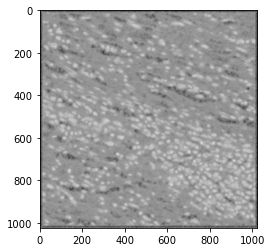

Actual Mask


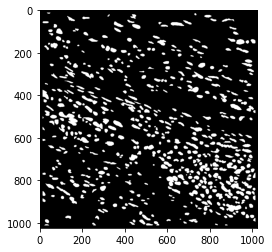

 37%|███▋      | 11/30 [01:23<02:24,  7.61s/it]

Train Epoch: 12 @ 08:23:09.186331 - Train Loss: 0.1944
Predicted Mask Sigmoid


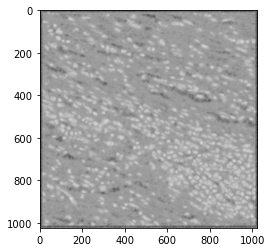

Actual Mask


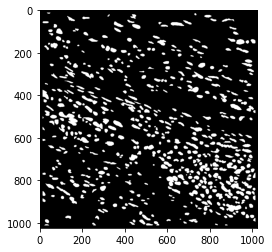

 40%|████      | 12/30 [01:31<02:16,  7.59s/it]

Train Epoch: 13 @ 08:23:17.866627 - Train Loss: 0.2017
Predicted Mask Sigmoid


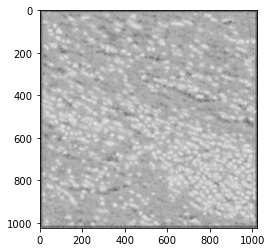

Actual Mask


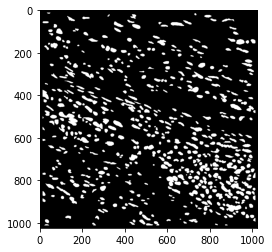

 43%|████▎     | 13/30 [01:39<02:14,  7.92s/it]

Train Epoch: 14 @ 08:23:28.563420 - Train Loss: 0.2007
Predicted Mask Sigmoid


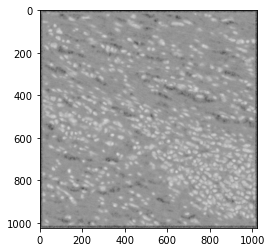

Actual Mask


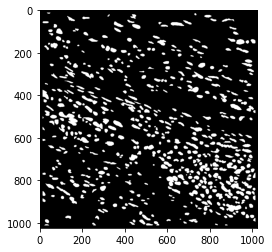

 47%|████▋     | 14/30 [01:50<02:20,  8.77s/it]

Train Epoch: 15 @ 08:23:36.106071 - Train Loss: 0.1974
Predicted Mask Sigmoid


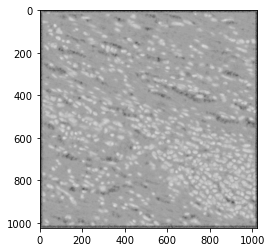

Actual Mask


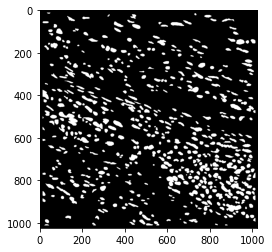

 50%|█████     | 15/30 [01:58<02:05,  8.38s/it]

Train Epoch: 16 @ 08:23:46.498465 - Train Loss: 0.1916
Predicted Mask Sigmoid


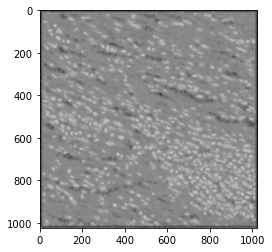

Actual Mask


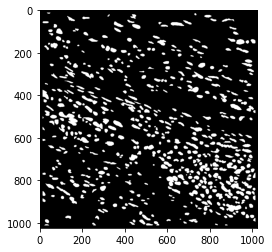

 53%|█████▎    | 16/30 [02:08<02:05,  8.99s/it]

Train Epoch: 17 @ 08:23:54.589528 - Train Loss: 0.1951
Predicted Mask Sigmoid


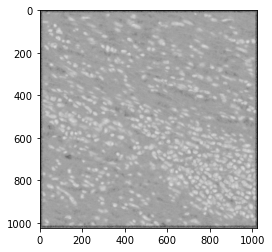

Actual Mask


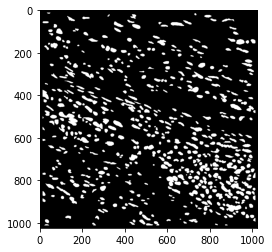

 57%|█████▋    | 17/30 [02:16<01:53,  8.72s/it]

Train Epoch: 18 @ 08:24:02.122458 - Train Loss: 0.1872
Predicted Mask Sigmoid


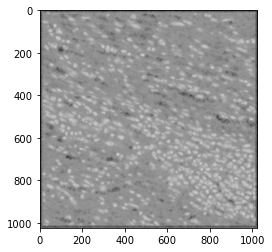

Actual Mask


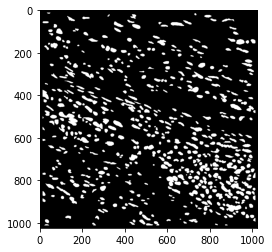

 60%|██████    | 18/30 [02:24<01:40,  8.36s/it]

Train Epoch: 19 @ 08:24:09.629950 - Train Loss: 0.1831
Predicted Mask Sigmoid


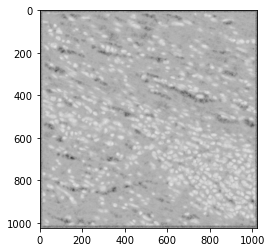

Actual Mask


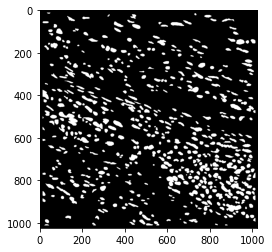

 63%|██████▎   | 19/30 [02:31<01:29,  8.11s/it]

Train Epoch: 20 @ 08:24:17.213496 - Train Loss: 0.1846
Predicted Mask Sigmoid


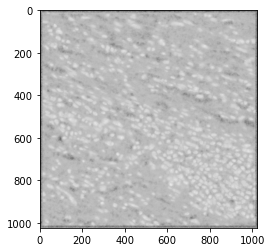

Actual Mask


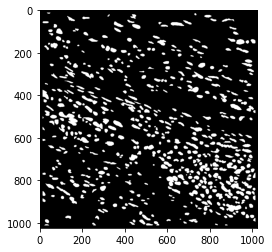

 67%|██████▋   | 20/30 [02:39<01:19,  7.95s/it]

Train Epoch: 21 @ 08:24:24.864953 - Train Loss: 0.1822
Predicted Mask Sigmoid


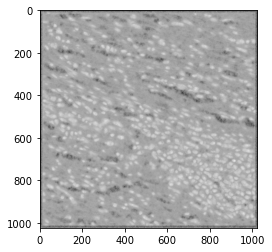

Actual Mask


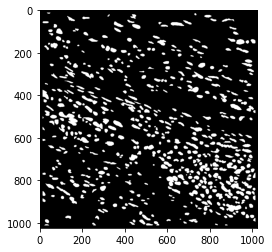

 70%|███████   | 21/30 [02:46<01:10,  7.88s/it]

Train Epoch: 22 @ 08:24:32.500745 - Train Loss: 0.1869
Predicted Mask Sigmoid


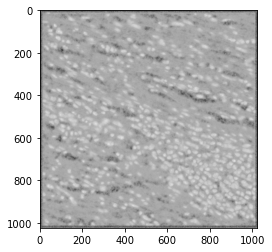

Actual Mask


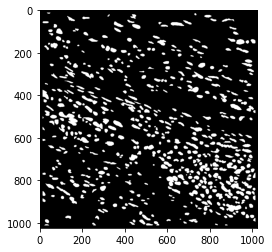

 73%|███████▎  | 22/30 [02:54<01:02,  7.78s/it]

Train Epoch: 23 @ 08:24:40.126533 - Train Loss: 0.1851
Predicted Mask Sigmoid


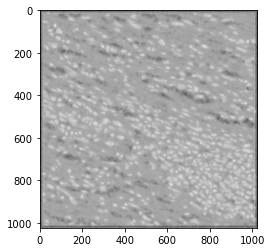

Actual Mask


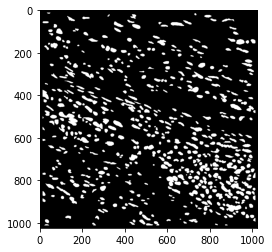

 77%|███████▋  | 23/30 [03:02<00:54,  7.74s/it]

Train Epoch: 24 @ 08:24:47.768298 - Train Loss: 0.1907
Predicted Mask Sigmoid


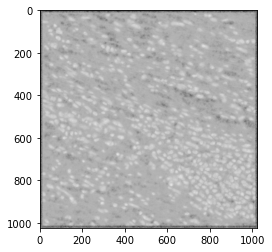

Actual Mask


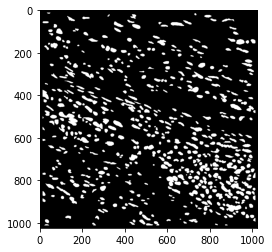

 80%|████████  | 24/30 [03:09<00:46,  7.71s/it]

Train Epoch: 25 @ 08:24:55.363053 - Train Loss: 0.1907
Predicted Mask Sigmoid


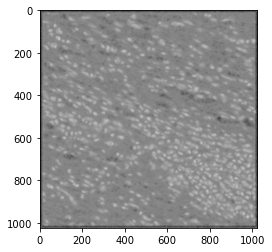

Actual Mask


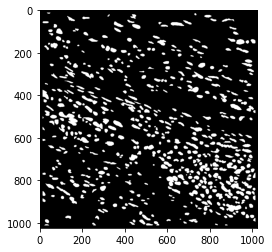

 83%|████████▎ | 25/30 [03:17<00:38,  7.67s/it]

Train Epoch: 26 @ 08:25:03.066621 - Train Loss: 0.1907
Predicted Mask Sigmoid


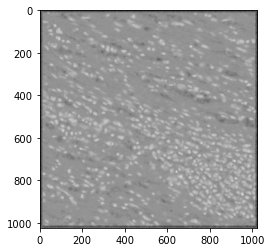

Actual Mask


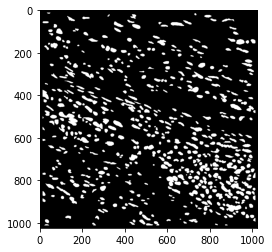

 87%|████████▋ | 26/30 [03:25<00:30,  7.68s/it]

Train Epoch: 27 @ 08:25:10.700029 - Train Loss: 0.2082
Predicted Mask Sigmoid


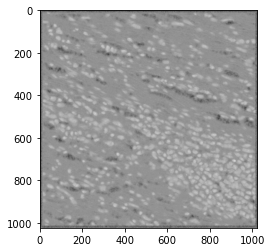

Actual Mask


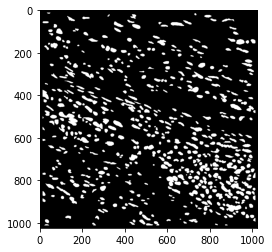

 90%|█████████ | 27/30 [03:32<00:23,  7.67s/it]

Train Epoch: 28 @ 08:25:18.218029 - Train Loss: 0.2100
Predicted Mask Sigmoid


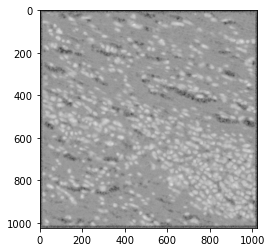

Actual Mask


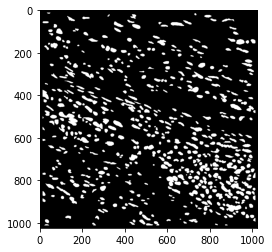

 93%|█████████▎| 28/30 [03:40<00:15,  7.64s/it]

Train Epoch: 29 @ 08:25:25.815256 - Train Loss: 0.1938
Predicted Mask Sigmoid


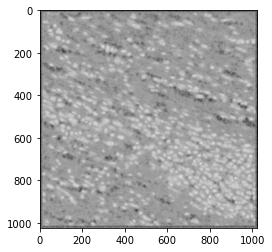

Actual Mask


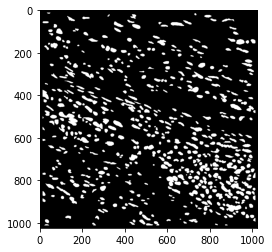

 97%|█████████▋| 29/30 [03:47<00:07,  7.61s/it]

Train Epoch: 30 @ 08:25:33.729192 - Train Loss: 0.1926
Predicted Mask Sigmoid


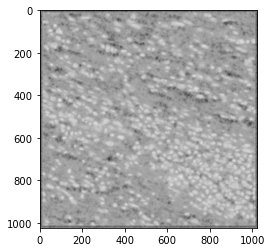

Actual Mask


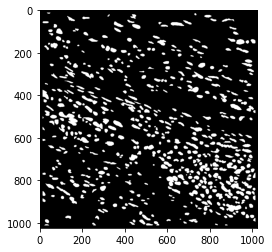

100%|██████████| 30/30 [03:55<00:00,  7.86s/it]


In [9]:
epochs = 30
train_losses = []

print("Training")
for epoch in tqdm(range(1, epochs + 1)):
    train_loss = train(model, device, train_dataloader, optimizer, epoch)
    train_losses.append(train_loss)

Input Image


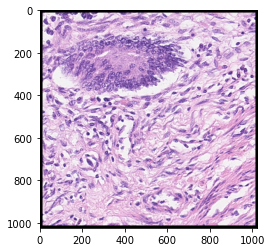

Predicted Mask Sigmoid


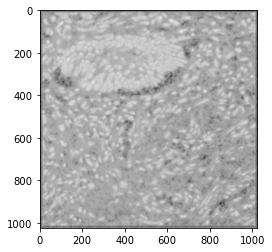

Predicted Mask Binary


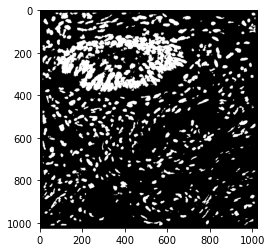

Actual Mask


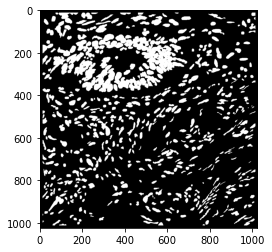

0.6537728594831334


In [10]:
for data, target in test_dataloader:
    print("Input Image")
    plt.imshow(data[0].numpy().transpose(1, 2, 0))
    plt.show()
    outputs = model(data.to(device))
    pred = outputs.to('cpu').detach().numpy()[0][0]

    print("Predicted Mask Sigmoid")
    plt.imshow(pred,cmap='gray')
    plt.show()
    threshold=0.95
    pred[pred >= threshold] = 1
    pred[pred < threshold] = 0
    print("Predicted Mask Binary")
    plt.imshow(pred,cmap='gray')
    plt.show()
    print("Actual Mask")
    plt.imshow(target[0],cmap='gray')
    plt.show()
    
    #iou
    target_ts = target[0].to('cpu').detach().numpy()
    intersection = np.logical_and(target_ts, pred)
    union = np.logical_or(target_ts, pred)
    iou_score = np.sum(intersection) / np.sum(union)
    print(iou_score)
    
    break